# Modeling & Fitting

In [1]:
import os
import sys
sys.path.insert(0, "../../")

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from core import util, config, database
from core.data.model import ModelDataRepo
from core.data.model.entities import *

database.init()
config.init_plot()

### Get Data

In [2]:
selected_kabko = "KOTA SURABAYA"
kabko = ModelDataRepo.get_kabko_full(selected_kabko)

### Make Model

In [3]:
from core.modeling import SeicrdRlcModel

mod = SeicrdRlcModel(kabko)

### Select Datsets to Use for Fitting

In [4]:
used_datasets = [
    "infectious", 
    "critical_cared", 
    #"infectious_all", 
    "recovered", 
    "dead",
    #"infected"
]
mod.use_datasets(used_datasets)

### List Variables that Can be Fitted

In [5]:
varying_init = [
    "death_time_over",
    "r_over", 
    "kapasitas_rs_mul", 
    "test_coverage_max", 
    "test_coverage_0", "test_coverage_increase", 
    "incubation_period", 
    "critical_time", "critical_chance",
    "death_time_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]

### Select Variables to Fit

In [6]:
varying_now = [
    #"death_time_over",
    #"r_over", 
    #"kapasitas_rs_mul", 
    #"test_coverage_max", 
    #"test_coverage_0", "test_coverage_increase", 
    "incubation_period", 
    "critical_time", "critical_chance",
    "death_time_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]
unvary = [x for x in varying_init if x not in varying_now]

### Fit!

In [7]:
result = mod.fit(test_splits=[2], unvary=unvary)
result

### Fit Results

Params Should Have "standard error" and "relative error" Columns. If they dont:
1. A parameter might not be significant
2. A parameter has hit its min/max limit and can't vary

In [8]:
result.fit_result.params

name,value,standard error,relative error,initial value,min,max,vary
days,118.000000,0.00000000,(0.00%),118,-inf,inf,False
population,2904751.00,0.00000000,(0.00%),2904751,-inf,inf,False
incubation_period,7.24028599,109.705482,(1515.21%),7.230245544676279,3.00000000,14.0000000,True
critical_chance,0.35457011,0.15770230,(44.48%),0.2938142848235992,0.01000000,0.41462596,True
critical_time,11.8373718,3.95176527,(33.38%),3.0257705798604535,3.00000000,12.0000000,True
recovery_time_normal,9.00000000,0.00000000,(0.00%),9.0,-inf,inf,False
recovery_time_critical,6.50000000,0.00000000,(0.00%),6.5,-inf,inf,False
death_chance_normal,0.13841519,0.90805138,(656.03%),0.32486220509282393,0.00500000,0.45064725,True
death_time_normal,9.81787951,51.0515077,(519.99%),6.139947224322423,5.00000000,10.0000000,True
death_chance_over,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False


### Model Scores

In [9]:
result.test_scorer.mean_absolute_error()

2635.2291735251024

In [10]:
result.test_scorer.explained_variance_score()

-48.262929676628374

In [11]:
result.fit_scorer.mean_absolute_error()

271.59343762296174

In [12]:
result.fit_scorer.explained_variance_score()

0.6915238346492067

### Predict

In [13]:
values = dict(result.fit_result.values)
values["days"] += 30
model_result = mod.model(**values)

### Plot!

In [14]:
from core.modeling import ModelPlotter

plotter = ModelPlotter(model_result)

In [15]:
length = kabko.data_count + result.outbreak_shift
length

118

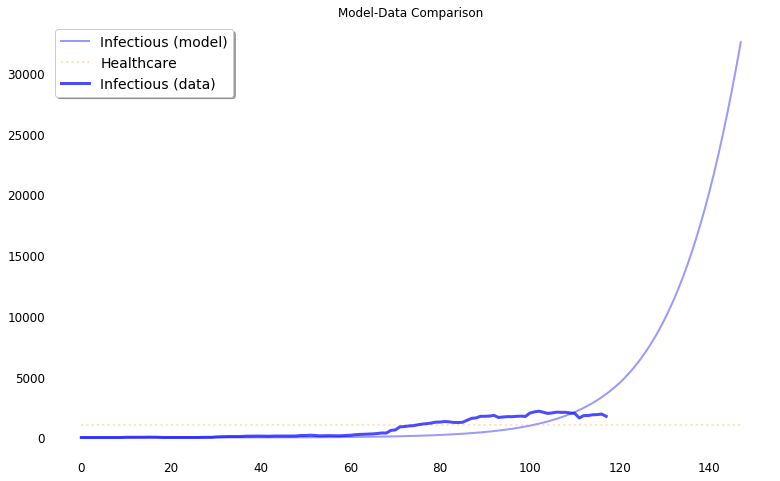

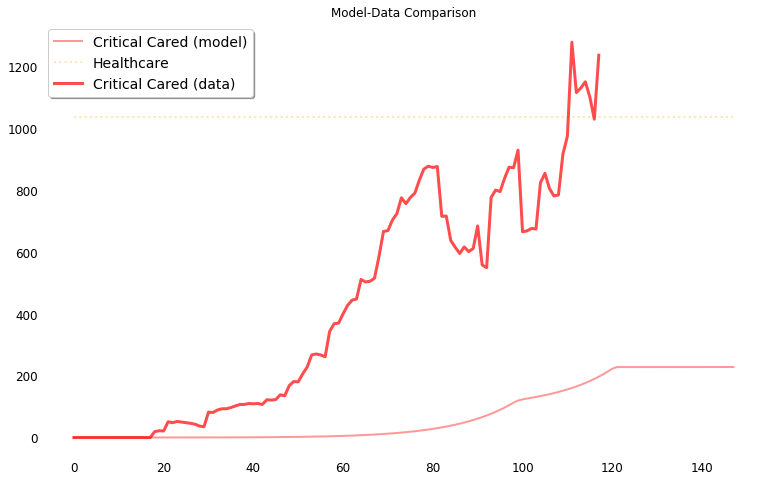

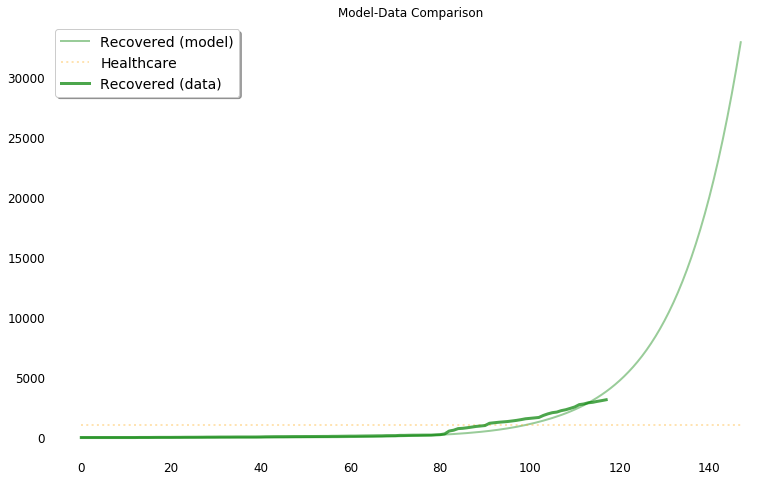

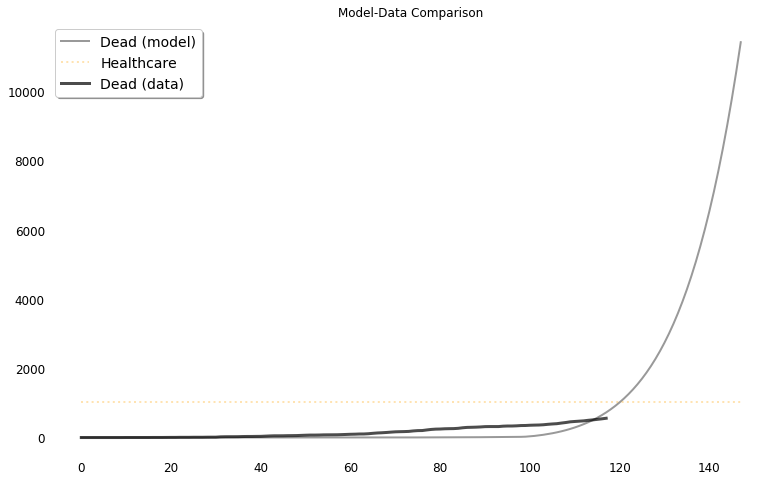

In [17]:
import matplotlib.pyplot as plt
for d in used_datasets:
    datasets = kabko.get_datasets([d], result.outbreak_shift)
    plotter.plot(
        plotter.plot_main_data, 
        datasets,
        length
    )
    plt.show()

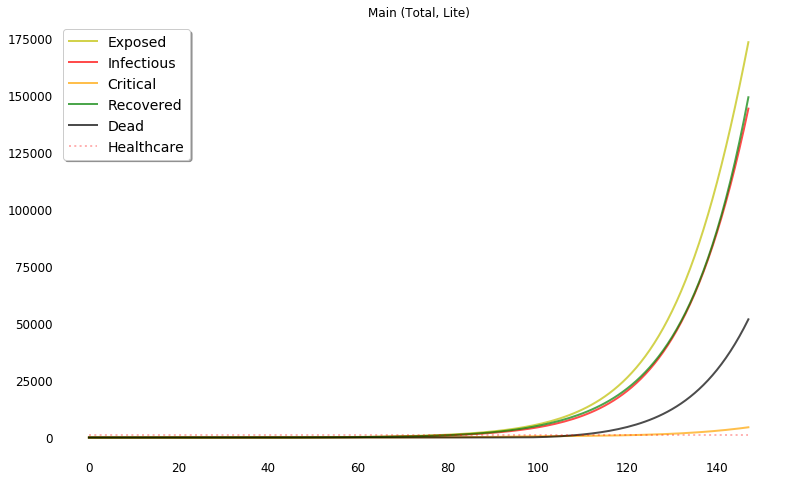

In [18]:
plotter.plot(plotter.plot_main_lite);

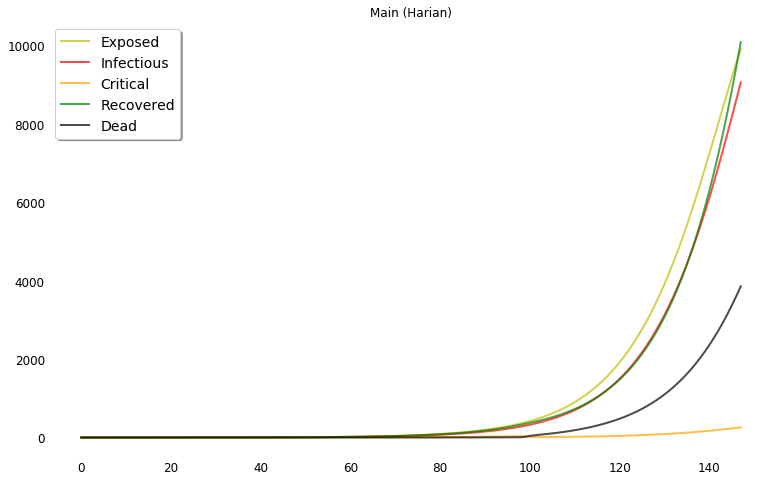

In [19]:
plotter.plot(plotter.plot_daily_lite);

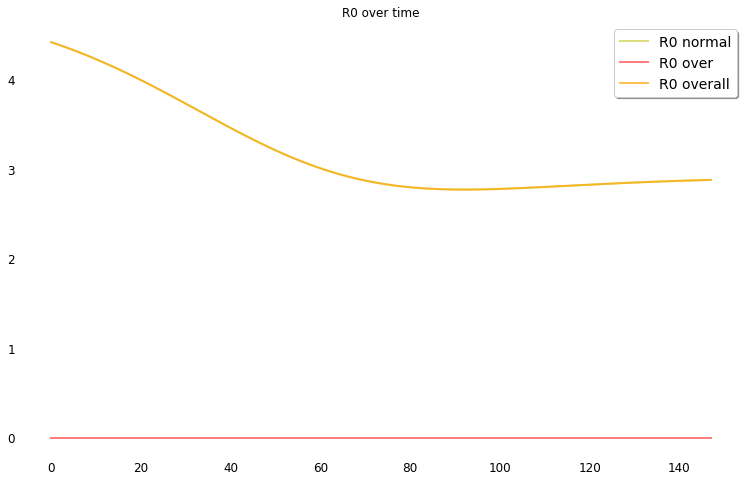

In [20]:
plotter.plot(plotter.plot_r0);

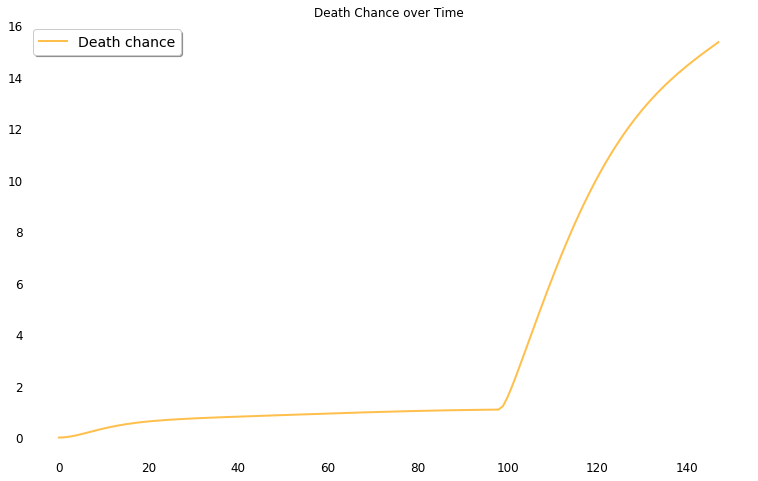

In [21]:
plotter.plot(plotter.plot_mortality_rate);

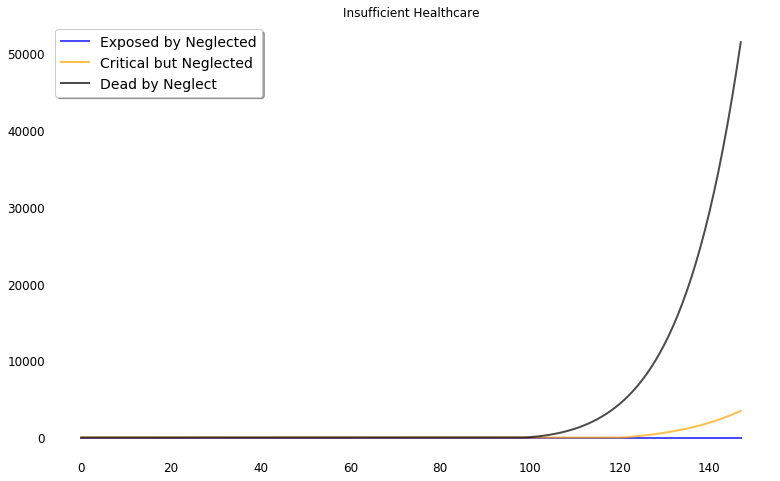

In [22]:
plotter.plot(plotter.plot_over);

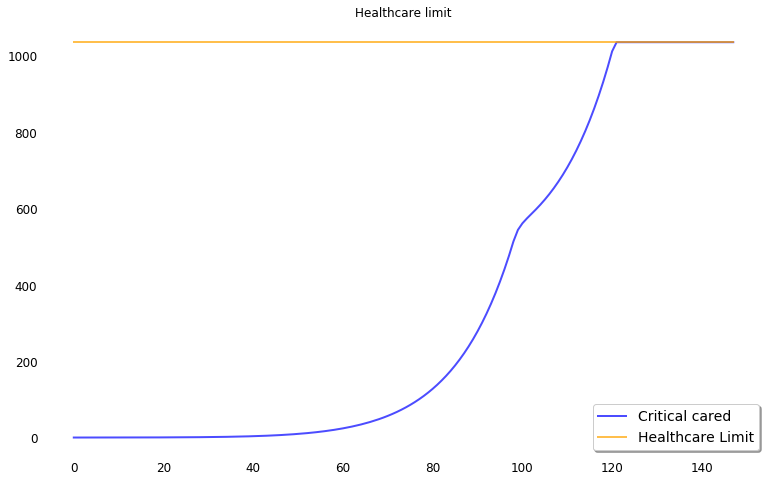

In [23]:
plotter.plot(plotter.plot_healthcare);

### Save Params

ModelDataRepo.update_all(result.kabko, result.fit_result.values, result.outbreak_shift)

### Confidence Interval

This requires standard error to be present for each params.

In [24]:
result.fit_result.conf_interval()

OrderedDict([('incubation_period',
              [(0.9973002039367398, -inf),
               (0.9544997361036416, -inf),
               (0.6826894921370859, -inf),
               (0.0, 7.240285994903367),
               (0.6826894921370859, inf),
               (0.9544997361036416, inf),
               (0.9973002039367398, inf)]),
             ('critical_chance',
              [(0.9973002039367398, -inf),
               (0.9544997361036416, -inf),
               (0.6826894921370859, -inf),
               (0.0, 0.3545701072226142),
               (0.6826894921370859, inf),
               (0.9544997361036416, inf),
               (0.9973002039367398, inf)]),
             ('critical_time',
              [(0.9973002039367398, -inf),
               (0.9544997361036416, -inf),
               (0.6826894921370859, -inf),
               (0.0, 11.837371843353873),
               (0.6826894921370859, inf),
               (0.9544997361036416, inf),
               (0.9973002039367398, inf)]),
     